# ch.5 오차 역전파 #

In [1]:
import numpy as np
import sys, os
sys.path.append(os.getcwd())

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self,x,y):
        self.x = x
        self.y = y
        
        return x*y
    
    def backward(self, dout): # 상류의 미분값
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy
        

In [3]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        
        return x+y
    
    def backward(self,dout):
        dx = dout * 1
        dy = dout * 1
        
        return dx, dy

### 덧셈계층와 곱셈계층 예제 ###

In [4]:
# buy_apple_orange

apple_num = 2
apple_price = 100
mandarin_num = 3
mandarin_price = 150
tax = 1.1

apple_layer = MulLayer()
mandarin_layer = MulLayer()

sum_layer = AddLayer()

tax_layer = MulLayer()

In [5]:
# 순전파
apple = apple_layer.forward(apple_num, apple_price)
mandarin = mandarin_layer.forward(mandarin_num, mandarin_price)
all_price = sum_layer.forward(apple, mandarin)
price = tax_layer.forward(tax, all_price)

In [6]:
price

715.0000000000001

In [7]:
# 역전파
dprice = 1
dtax, dall_price = tax_layer.backward(dprice)
dapple, dmandarin = sum_layer.backward(dall_price)
dapple_num, dapple_price = apple_layer.backward(dapple)
dmandarin_num, dmandarin_price = mandarin_layer.backward(dmandarin)

In [8]:
dmandarin_num, dmandarin_price

(165.0, 3.3000000000000003)

In [9]:
dapple_num, dapple_price

(110.00000000000001, 2.2)

In [20]:
dtax, dall_price

(650, 1.1)

In [2]:
class ReLu:
    # np.array 형태의 input, output을 가정
    def __init__(self):
        self.mask = None # 0보다 큰지 작은지 저장
        
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()  # shallow copy
        out[self.mask] = 0 # mask 가 true일때 0을 return 하도록
        
        return out
    
    def backward(self,dout):
        dout[self.mask] = 0 
        dx = dout # 나머지는 *1 이라 변화 없음
        
        return dx

In [34]:
x = np.array([[1,-0.5],[-2.0,3.0]])

layer = ReLu()
layer.forward(x)

array([[1., 0.],
       [0., 3.]])

In [3]:
class sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1/(1+exp(-x))
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) *self.out
        
        return dx        

### Affine Transform ###

In [4]:
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.X = None
        self.dW = None
        self.db = None
        
    def forward(self,X):
        self.X = X
        out = np.dot(X,self.W)+self.b  
        
        return out
    
    def backward(self,dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout) # 순서주의
        self.db = np.sum(dout, axis = 0) # 상류의 dout을 데이터마다 더함
        
        return dX

### softmax with loss ###

In [5]:
from scratch.common.functions import softmax, cross_entropy_error

In [6]:
class SoftmaxWithLoss:
    def __init_(self):
        self.loss = None
        self.y = None # softmax결과
        self.t = None # 정답
        
    def forward(self, x, t): # 추정치, 정답
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout = 1): # dL/dL =1
        batch_size = self.t.shape[0] # 데이터 수
        dx = (self.y -self.t)/batch_size # 부록 A 291p참고
        
        return dx

### 오차 역전파를 이용한 신경망 구현 - 2층 신경망 ###

ch.4 에서는 기울기 산출을 위해 gradient를 이용하고 그를 training loss와 곱해 parameter들을 update시켰다.(gradient descent) 이번 chatper에서는 오차 역전파를 이용해 기울기를 구한후 parameter를 업데이트 할 것 이다. 이 방법을 이용하여 2층 신경망을 만들어 보자!


*/ 기울기는 손실함수의 값을 가장 작게 만들수 있는 방향을 제시한다 /* 

In [7]:
from scratch.common.gradient import numerical_gradient
from collections import OrderedDict

In [8]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        # parameter 초기화
        self.params={}
        
        self.params['W1'] = weight_init_std*np.random.rand(input_size,hidden_size)
        self.params['W2'] = weight_init_std*np.random.rand(hidden_size,output_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
    
        # 계층 만들기
        self.layers = OrderedDict() # 순서가 있는 dictionary -> 추가한 순서를 기억한다.
        self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLu1'] = ReLu()
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['ReLu2'] = ReLu()
        self.lastLayer = SoftmaxWithLoss()
        
        
        # 활성화값 확일을 위한 공간
        self.activation = {}
        
    def predict(self, x):
        for index,layer in enumerate(self.layers.values()): # layers는 dictionary 이므로 values()필요
            x = layer.forward(x) # 각 계층에 forward가 구현되어 있음
            
            # 활성화 값 확인을 위한 준비 과정
            if isinstance(layer,ReLu):
                self.activation[index]=x
            
        return x # 모든 layer를 지난 결과
    
    def loss(self, x, t):
        y = self.predict(x) # 추정치
        
        return self.lastLayer.forward(y,t)
        
    def accuracy(self, x, t):      # 전체 데이터 중에서 올바른 추정 비율
        y = self.predict(x)        # 출력 (1 x n)  # 각 label별 계산 결과
        y = np.argmax(y, axis = 1) # 1x1 로 변환
        
        if t.ndim != 1: t = np.argmax(t, axis = 1)  # 1x1 형태로 변환 (원래 one hot vector 형태였음)
            
        accuracy = np.sum(y==t) / float(x.shape[0]) # 올바른 추정 수 /전체 데이터 수
        
        return accuracy
    
    # ch.4 방식 - 직접 gradient 계산하기
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    # 오차 역전파를 이용한 gradient 구하기
    def gradient(self, x, t):
        
        #  순전파
        self.loss(x, t)
        
        # dL/dL = 1
        dout = 1            
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values()) # 순서를 뒤집기 위해 list로 변경
        layers.reverse()
        
        # 역전파 진행
        for layer in layers:
            dout = layer.backward(dout)
            # backward를 진행하면서 각 layer내 dX,dY등이 업데이트 됨 (저장됨)
            
        # 결과 저장
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads 

In [118]:
network=TwoLayerNet(725,100,10)

In [123]:
for k, v in enumerate(network.layers):
    print(type(k))
    print(type(v))

<class 'int'>
<class 'str'>
<class 'int'>
<class 'str'>
<class 'int'>
<class 'str'>
<class 'int'>
<class 'str'>


### 오차 역전파를 이용한 gradient 계산 - numerical gradient와 비교 ###

In [9]:
from scratch.dataset.mnist import load_mnist

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10) # 28x28 -> 0-9label

# 3x784 batch
x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

In [ ]:
from matplotlib import pyplot as plt

for i in x_batch:
    plt.imshow(i.reshape(28,28), cmap='gray')
    plt.show()

In [ ]:
print(grad_backprop['b2'])

In [11]:
for key in grad_numerical.keys():
    diff = np.average(np.abs( grad_backprop[key] - grad_numerical[key] ))
    print(key,':',diff)

W1 : 2.304054129820859e-10
b1 : 1.1113163406379668e-09
W2 : 7.006720959318313e-08
b2 : 1.3685408491032058e-07


numerical_gradient와 오차 역전파 법으로 구한 기울기의 차이가 매우 작다

### 오차 역전파를 이용한 신경망 학습 - 2층 신경망 ###

In [19]:
t_train.shape

(60000, 10)

In [23]:
train_size/batch_size

600.0

In [11]:
import time

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]
last_acc_list=[]
time_list=[]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인

for j in range(5):
    # reset
    start = time.time()
    network = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10) # 28x28 -> 0-9label
    for i in range(iteration):
        # mini batch생성
        batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # gradient구하기 (오차 역전파법)
        grad = network.gradient(x_batch, t_batch)

        # parameter update
        for key in ('W1','b1','W2','b2'):
            network.params[key] -= learning_rate * grad[key]

        # 업데이트된 parameter로 loss 계산
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i==(iteration-1):
            # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
            train_acc = network.accuracy(x_train, t_train) 
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(i,':',train_acc, test_acc)

    end = time.time()
    time_list.append(end-start)
    print(f'소요시간: {time_list[-1]}')
    last_acc_list.append(test_acc)
    
print(f'5회 평균 test accuracy: {np.average(last_acc_list)}')
print(f'5회 평균 소요 시간: {np.average(time_list)}')

9999 : 0.9761333333333333 0.9688
소요시간: 37.95861029624939
9999 : 0.8821166666666667 0.8735
소요시간: 44.46683430671692
9999 : 0.9771666666666666 0.9695
소요시간: 42.549105644226074
9999 : 0.8826666666666667 0.8738
소요시간: 39.174416065216064
9999 : 0.9746333333333334 0.9665
소요시간: 32.03793716430664
5회 평균 test accuracy: 0.93042
5회 평균 소요 시간: 39.23738069534302


### 5층 신경망 ###

In [131]:
class FiveLayerNet:
    def __init__(self, i, h1, h2, h3, h4, o, weight_init_std=0.01):
        
        # parameter 초기화
        self.params={}
        
        self.params['W1'] = weight_init_std*np.random.rand(i,h1)
        self.params['W2'] = weight_init_std*np.random.rand(h1,h2)
        self.params['W3'] = weight_init_std*np.random.rand(h2,h3)
        self.params['W4'] = weight_init_std*np.random.rand(h3,h4)
        self.params['W5'] = weight_init_std*np.random.rand(h4,o)
        
        self.params['b1'] = np.zeros(h1)
        self.params['b2'] = np.zeros(h2)
        self.params['b3'] = np.zeros(h3)
        self.params['b4'] = np.zeros(h4)
        self.params['b5'] = np.zeros(o)
    
        # 계층 만들기
        self.layers = OrderedDict() # 순서가 있는 dictionary -> 추가한 순서를 기억한다.
        self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLu1'] = ReLu()
        
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['ReLu2'] = ReLu()
        
        self.layers['Affine3'] = Affine(self.params['W3'],self.params['b3'])
        self.layers['ReLu3'] = ReLu()
        
        self.layers['Affine4'] = Affine(self.params['W4'],self.params['b4'])
        self.layers['ReLu4'] = ReLu()
        
        self.layers['Affine5'] = Affine(self.params['W5'],self.params['b5'])
        self.layers['ReLu5'] = ReLu()
        
        self.lastLayer = SoftmaxWithLoss()
        
        # 활성화값 저장을 위한 공간
        self.activation = {}
        
    def predict(self, x):
        for index,layer in enumerate(self.layers.values()): # layers는 dictionary 이므로 values()필요
            x = layer.forward(x) # 각 계층에 forward가 구현되어 있음
            
            if isinstance(layer,ReLu):
                self.activation[index]=x
            
        return x # 모든 layer를 지난 결과
    
    def loss(self, x, t):
        y = self.predict(x) # 추정치
        
        return self.lastLayer.forward(y,t)
        
    def accuracy(self, x, t):      # 전체 데이터 중에서 올바른 추정 비율
        y = self.predict(x)        # 출력 (1 x n)  # 각 label별 계산 결과
        y = np.argmax(y, axis = 1) # 1x1 로 변환
        
        if t.ndim != 1: t = np.argmax(t, axis = 1)  # 1x1 형태로 변환 (원래 one hot vector 형태였음)
            
        accuracy = np.sum(y==t) / float(x.shape[0]) # 올바른 추정 수 /전체 데이터 수
        
        return accuracy
    
    # ch.4 방식 - 직접 gradient 계산하기
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        grads['W5'] = numerical_gradient(loss_W, self.params['W5'])
        grads['b5'] = numerical_gradient(loss_W, self.params['b5'])
        
        return grads
        
    # 오차 역전파를 이용한 gradient 구하기
    def gradient(self, x, t):
        
        #  순전파
        self.loss(x, t)
        
        # dL/dL = 1
        dout = 1            
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values()) # 순서를 뒤집기 위해 list로 변경
        layers.reverse()
        
        # 역전파 진행
        for layer in layers:
            dout = layer.backward(dout)
            # backward를 진행하면서 각 layer내 dX,dY등이 업데이트 됨 (저장됨)
            
        # 결과 저장
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        grads['W4'] = self.layers['Affine4'].dW
        grads['b4'] = self.layers['Affine4'].db
        grads['W5'] = self.layers['Affine5'].dW
        grads['b5'] = self.layers['Affine5'].db
        
        return grads 

In [33]:
network = FiveLayerNet(i=784,h1=100,h2=50,h3=20,h4=15,o=10) # 28x28 -> 0-9label

In [35]:
# numerical gradient 이용해 검증

# 3x784 batch
x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

In [36]:
for key in grad_numerical.keys():
    diff = np.average(np.abs( grad_backprop[key] - grad_numerical[key] ))
    print(key,':',diff)

W1 : 3.816286335171209e-13
b1 : 1.0530893949987353e-12
W2 : 1.361757074749436e-12
b2 : 1.4478180719966646e-12
W3 : 5.067685943924462e-12
b3 : 1.5827905806450566e-11
W4 : 6.620667798918414e-11
b4 : 9.475654732070172e-10
W5 : 8.712166448262999e-10
b5 : 1.39947644141325e-07


In [172]:
import time

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)



iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]
last_acc_list=[]
time_list=[]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인


for j in range(5):
    # reset
    start = time.time()
    network = FiveLayerNet(i=784,h1=500,h2=250,h3=100,h4=40,o=10,weight_init_std=0.007) # 28x28 -> 0-9label
    for i in range(iteration):
        # mini batch생성
        batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # gradient구하기 (오차 역전파법)
        grad = network.gradient(x_batch, t_batch)

        # parameter update
        for key in ('W1','b1','W2','b2','W3','b3','W4','b4','W5','b5'):
            network.params[key] -= learning_rate * grad[key]

        # 업데이트된 parameter로 loss 계산
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0 or i==(iteration-1):
            # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
            train_acc = network.accuracy(x_train, t_train) 
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(i,':',train_acc, test_acc)

        if i == (iteration-1):
            last_acc_list.append(test_acc)
        
           
    end = time.time()
    time_list.append(end-start)
    print(f'소요시간: {time_list[-1]}')
    
print(f'5회 평균 test accuracy: {np.average(last_acc_list)}')
print(f'5회 평균 소요 시간: {np.average(time_list)}')

0 : 0.09863333333333334 0.0958
600 : 0.29035 0.2897
1200 : 0.3624833333333333 0.3601
1800 : 0.42141666666666666 0.4264
2400 : 0.35296666666666665 0.3579
3000 : 0.4968666666666667 0.4849
3600 : 0.4976 0.506
4200 : 0.5759 0.5755
4800 : 0.5400833333333334 0.5362
5400 : 0.51895 0.5203
6000 : 0.5360333333333334 0.5337
6600 : 0.4648833333333333 0.4649
7200 : 0.4853 0.4855
7800 : 0.49111666666666665 0.4872
8400 : 0.49373333333333336 0.4896
9000 : 0.49596666666666667 0.4912
9600 : 0.49583333333333335 0.4906
9999 : 0.4975 0.4928
소요시간: 177.15410828590393
0 : 0.10111666666666666 0.0994
600 : 0.24991666666666668 0.2535
1200 : 0.3486 0.3573
1800 : 0.3609833333333333 0.3602
2400 : 0.42975 0.4338
3000 : 0.43635 0.4338
3600 : 0.41845 0.4225
4200 : 0.52745 0.5273
4800 : 0.5377833333333333 0.5403
5400 : 0.5570333333333334 0.5538
6000 : 0.5577666666666666 0.5513
6600 : 0.5729833333333333 0.5681
7200 : 0.6329333333333333 0.6319
7800 : 0.51055 0.5054
8400 : 0.7479 0.7409
9000 : 0.7499666666666667 0.7514
96

학습이 되지 않거나 오히려 정확도가 떨어지게 되는 구간이 발생 (ch6의 204p참고 - 기울기 소실 문제)

# 활성화값 분포 확인

ch6 에서 소개하는 활성화값 분포를 통해 은닉층이 제대로 역할을 다 하고 있는지 확인해 보도록 하겠다. 아래의 TwoLayerNet은 저번 실험결과 학습이 잘 되어 정확도가 96퍼센트 가량 나왔다. 학습이 잘된 경우의 활성화 값과 그렇지 않는 경우의 비교를 위해 TwoLayerNet의 활성화 값분포 먼저 히스토그램으로 표현하겠다. 

학습이 충분히 이루어진후의 활성화 함수를 확인해야만 한다. 이를 위해서는 TwoLayerNet과 FiveLayerNet내부에 활성화값 저장 장소를 만들어야 하며, 학습과정과 관련된 코드도 일부 수정이 필요하다. 

In [156]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)


iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인

network = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10) # 28x28 -> 0-9label
for i in range(1):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad = network.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]

    # 업데이트된 parameter로 loss 계산
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i==(iteration-1) or i % iter_per_epoch ==0:
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
        train_acc = network.accuracy(x_train, t_train) 
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(i,':',train_acc, test_acc)

0 : 0.09863333333333334 0.0958


(array([6.0400e+02, 1.0408e+04, 2.4890e+04, 2.5134e+04, 1.7250e+04,
        1.0363e+04, 5.5640e+03, 3.0440e+03, 1.5680e+03, 6.4500e+02,
        2.9300e+02, 1.5000e+02, 6.0000e+01, 2.3000e+01, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

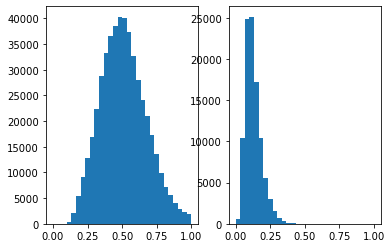

In [157]:
# 초기 활성화값 분포
plt.subplot(1,2,1)
plt.hist(network.activation[1].flatten(),30,range=(0,1))
plt.subplot(1,2,2)
plt.hist(network.activation[3].flatten(),30,range=(0,1))

(array([38186.,   254.,   221.,   257.,   231.,   263.,   254.,   264.,
          256.,   246.,   275.,   263.,   299.,   262.,   276.,   262.,
          285.,   255.,   272.,   254.,   266.,   296.,   279.,   303.,
          276.,   258.,   271.,   266.,   283.,   274.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

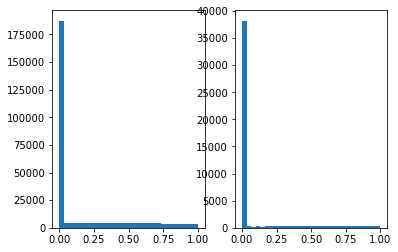

In [155]:
# 10000번 학습후 활성화값 분포
plt.subplot(1,2,1)
plt.hist(network.activation[1].flatten(),30,range=(0,1))
plt.subplot(1,2,2)
plt.hist(network.activation[3].flatten(),30,range=(0,1))

### 5층 신경망의  학습후 활성화값 분포 확인 ###

In [170]:

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)



iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인

network = FiveLayerNet(i=784,h1=500,h2=250,h3=100,h4=40,o=10, weight_init_std=0.1) # 28x28 -> 0-9label
for i in range(1):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad = network.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4','W5','b5'):
        network.params[key] -= learning_rate * grad[key]

    # 업데이트된 parameter로 loss 계산
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0 or i==(iteration-1):
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
        train_acc = network.accuracy(x_train, t_train) 
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(i,':',train_acc, test_acc)

    if i == (iteration-1):
        last_acc_list.append(test_acc)



0 : 0.10218333333333333 0.101


In [137]:
len(network.activation)

5

In [141]:
network.activation.keys()

dict_keys([1, 3, 5, 7, 9])

<function matplotlib.pyplot.show(close=None, block=None)>

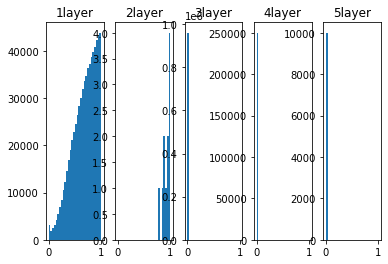

In [171]:
# 초기 활성화값 분포 - std=0.1
for i,k in enumerate(network.activation.keys()):
    plt.subplot(1, 5,i+1)
    plt.title(str(i+1)+'layer')
    plt.hist(network.activation[k].flatten(),30,range=(0,1))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

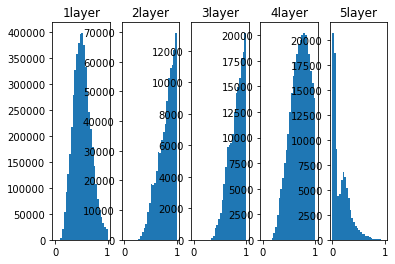

In [159]:
# 초기 활성화값 분포 - std=0.01
for i,k in enumerate(network.activation.keys()):
    plt.subplot(1, 5,i+1)
    plt.title(str(i+1)+'layer')
    plt.hist(network.activation[k].flatten(),30,range=(0,1))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

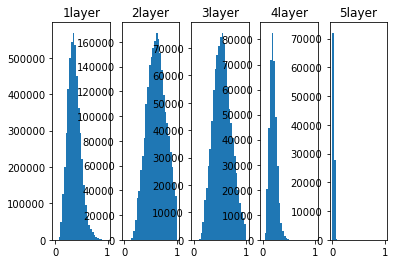

In [167]:
# 초기 활성화값 분포 - std=0.007
for i,k in enumerate(network.activation.keys()):
    plt.subplot(1, 5,i+1)
    plt.title(str(i+1)+'layer')
    plt.hist(network.activation[k].flatten(),30,range=(0,1))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

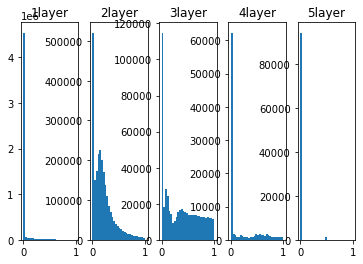

In [149]:
# 10000번 학습후 활성화값 분포
for i,k in enumerate(network.activation.keys()):
    plt.subplot(1, 5,i+1)
    plt.title(str(i+1)+'layer')
    plt.hist(network.activation[k].flatten(),30,range=(0,1))
plt.show